In [9]:
import joblib
import pandas as pd
import os
import image_similarity as imgsim
import numpy as np
from ultralytics import YOLO
import cv2


Двухстадиный процесс: 
1. Кассификация изображения с подготовленной модели кластеризации
2. Применение модели детекции для полученного кластера

In [12]:
# load cluster model
cluster_model_fname = "../weights/cluster_model.joblib"
cluster_model = joblib.load(cluster_model_fname)

In [16]:
# load detector models for every cluster
models = [YOLO("../weights/yolo11n-seg_850_550ep.pt"), 
          YOLO("../weights/yolo11n-seg_850_550ep.pt"),
          YOLO("../weights/yolo11n-seg_850_300ep.pt")]

In [32]:
# load test image 
dataset_dir = os.path.dirname(os.path.dirname(os.getcwd()))
test_image_fname = os.path.join(dataset_dir, "train_dataset/cv_test_dataset/1709046334_0.jpg")
mask_image_fname = os.path.join(dataset_dir, "train_dataset/cv_test_dataset/1709046334_0.png")
res_image_fname = os.path.join(dataset_dir, "train_dataset/cv_test_dataset/mask_image.png")

image = cv2.imread(test_image_fname)

In [33]:
# build embeddnig for test image
ImgSim = imgsim.Img2Vec('resnet18', weights='DEFAULT')

embedding = ImgSim.embed_image(test_image_fname).cpu().detach().numpy()
embeddings = np.array([embedding.reshape((-1))])

In [34]:
def infer_model(image, embedding): 
    # get image embedding cluster id 
    cluster_id  = cluster_model.predict(embeddings)[0]

    # apply appropriate detector model
    return models[cluster_id](image)


In [25]:
# Функция для создания маски с черным фоном
def create_mask(image_path, results):
    # Загружаем изображение и переводим в градации серого
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Создаем пустую маску с черным фоном
    mask = np.zeros((height, width), dtype=np.uint8)

    # Проходим по результатам и создаем маску
    for result in results:
        masks = result.masks  # Получаем маски из результатов
        if masks is not None:
            for mask_array in masks.data:  # Получаем маски как массивы
                mask_i = mask_array.cpu().numpy()  # Преобразуем маску в numpy массив
                
                # Изменяем размер маски под размер оригинального изображения
                mask_i_resized = cv2.resize(mask_i, (width, height), interpolation=cv2.INTER_LINEAR)
                
                # Накладываем маску на пустую маску (255 для белого)
                mask[mask_i_resized > 0] = 255

    return mask

In [35]:
results = infer_model(image, embedding)
mask_image = create_mask(test_image_fname, results)


0: 512x864 4 contaminateds, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 864)


In [36]:
image = cv2.imread(test_image_fname)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_image_fname)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

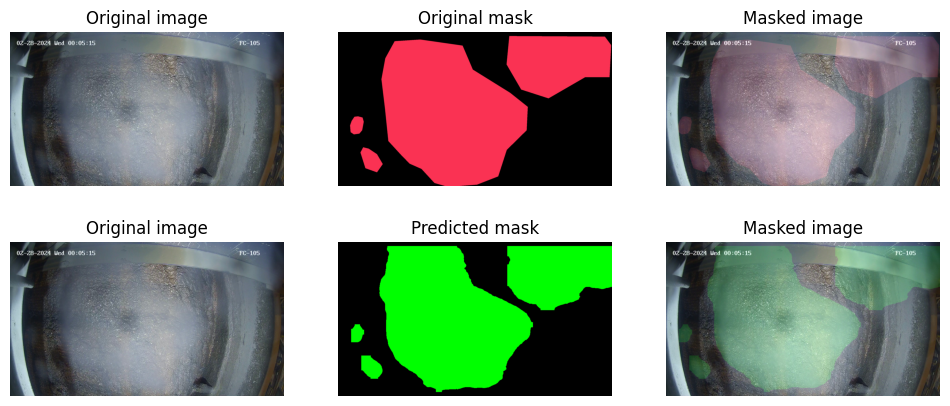

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

plt.subplot(2, 3, 1)  
plt.imshow(image)
plt.axis('off')  # Hide the axis labels
plt.title("Original image") 

plt.subplot(2, 3, 2)
plt.imshow(mask)
plt.axis('off')  # Hide the axis labels
plt.title("Original mask") 

masked_image = cv2.addWeighted(image, 1, mask, 0.15, 0)

plt.subplot(2, 3, 3)
plt.imshow(masked_image)
plt.axis('off')  # Hide the axis labels
plt.title("Masked image")

plt.subplot(2, 3, 4)  
plt.imshow(image)
plt.axis('off')  # Hide the axis labels
plt.title("Original image") 

rgb_mask = np.zeros_like(image)
rgb_mask[:,:,1] = mask_image

plt.subplot(2, 3, 5)
plt.imshow(rgb_mask)
plt.axis('off')  # Hide the axis labels
plt.title("Predicted mask") 

masked_image = cv2.addWeighted(image, 1, rgb_mask, 0.15, 0)

plt.subplot(2, 3, 6)
plt.imshow(masked_image)
plt.axis('off')  # Hide the axis labels
plt.title("Masked image")

plt.show()